# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

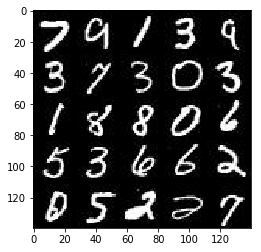

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

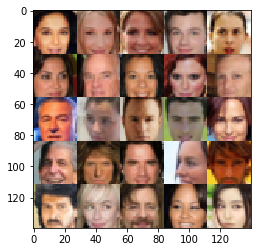

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_inputs') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs') 
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2, stddev=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        L1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        L1 = tf.maximum(alpha * L1, L1)
        # 14x14x64

        L2 = tf.layers.conv2d(L1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        L2 = tf.layers.batch_normalization(L2, training=True)
        L2 = tf.maximum(alpha * L2, L2)
        # 7x7x128

        L3 = tf.layers.conv2d(L2, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        L3 = tf.layers.batch_normalization(L3, training=True)
        L3 = tf.maximum(alpha * L3, L3)
        # 4x4x256

        L4 = tf.layers.conv2d(L3, 512, 3, strides=2, padding='same')
        L4 = tf.layers.batch_normalization(L4, training=True)
        L4 = tf.maximum(alpha * L4, L4)
        # 2x2x512

        flat   = tf.contrib.layers.flatten(L4)
        logits = tf.layers.dense(flat, 1)
        out    = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully connected
        L1 = tf.layers.dense(z, 2*2*512)
        
        # Start the convolution
        L1 = tf.reshape(L1, (-1, 2, 2, 512))
        L1 = tf.layers.batch_normalization(L1, training=is_train)
        L1 = tf.maximum(alpha * L1, L1)
        # 2x2x512

        L2 = tf.layers.conv2d_transpose(L1, 256, 3, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        L2 = tf.layers.batch_normalization(L2, training=is_train)
        L2 = tf.maximum(alpha * L2, L2)        
        # 4x4x256

        L3 = tf.layers.conv2d_transpose(L2, 128, 4, strides=1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        L3 = tf.layers.batch_normalization(L3, training=is_train)
        L3 = tf.maximum(alpha * L3, L3)
        # 7x7x128
    
        L4 = tf.layers.conv2d_transpose(L3, 64, 3, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        L4 = tf.layers.batch_normalization(L4, training=is_train)
        L4 = tf.maximum(alpha * L4, L4)
        # 14x14x64
        
        logits = tf.layers.conv2d_transpose(L4, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out    = tf.tanh(logits) 
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates  = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Set image dimensions
    _, image_width, image_height, image_channels = data_shape
    # Set model inputs
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    # Set model loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    # Set model optimization
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps    = 0
    
    saver    = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                # Sample random noise for G
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: sample_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: sample_z, learn_rate: learning_rate}) 
            
                                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: sample_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: sample_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 30, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.8879... Generator Loss: 0.0021
Epoch 1/2... Discriminator Loss: 5.9125... Generator Loss: 0.0043
Epoch 1/2... Discriminator Loss: 0.8804... Generator Loss: 0.9438
Epoch 1/2... Discriminator Loss: 3.0543... Generator Loss: 9.4564
Epoch 1/2... Discriminator Loss: 0.6967... Generator Loss: 3.5442
Epoch 1/2... Discriminator Loss: 0.3636... Generator Loss: 6.1483
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 2.9942
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 1.5465
Epoch 1/2... Discriminator Loss: 0.4285... Generator Loss: 2.8275
Epoch 1/2... Discriminator Loss: 0.6916... Generator Loss: 6.4144


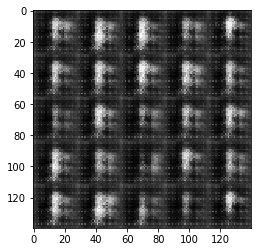

Epoch 1/2... Discriminator Loss: 0.3987... Generator Loss: 3.3963
Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 4.7853
Epoch 1/2... Discriminator Loss: 0.4650... Generator Loss: 5.5835
Epoch 1/2... Discriminator Loss: 0.3980... Generator Loss: 4.5046
Epoch 1/2... Discriminator Loss: 0.5915... Generator Loss: 6.5098
Epoch 1/2... Discriminator Loss: 0.4612... Generator Loss: 2.6844
Epoch 1/2... Discriminator Loss: 2.8541... Generator Loss: 10.7263
Epoch 1/2... Discriminator Loss: 0.4197... Generator Loss: 3.0417
Epoch 1/2... Discriminator Loss: 0.6303... Generator Loss: 1.9389
Epoch 1/2... Discriminator Loss: 0.5057... Generator Loss: 2.4693


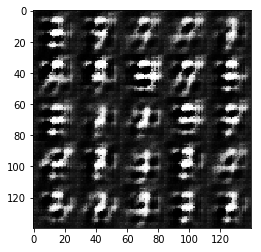

Epoch 1/2... Discriminator Loss: 0.5116... Generator Loss: 2.5998
Epoch 1/2... Discriminator Loss: 0.6214... Generator Loss: 1.6301
Epoch 1/2... Discriminator Loss: 0.5864... Generator Loss: 2.3026
Epoch 1/2... Discriminator Loss: 0.5466... Generator Loss: 2.8938
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 1.7785
Epoch 1/2... Discriminator Loss: 0.7675... Generator Loss: 3.4987
Epoch 1/2... Discriminator Loss: 0.5846... Generator Loss: 2.4689
Epoch 1/2... Discriminator Loss: 2.2301... Generator Loss: 0.4190
Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 2.8971
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.9703


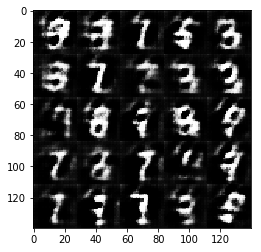

Epoch 1/2... Discriminator Loss: 0.4747... Generator Loss: 2.7120
Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 1.6755
Epoch 1/2... Discriminator Loss: 0.6599... Generator Loss: 3.3024
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 1.8398
Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 2.8101
Epoch 1/2... Discriminator Loss: 0.6072... Generator Loss: 3.6302
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 2.0203
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 1.2977
Epoch 1/2... Discriminator Loss: 0.5972... Generator Loss: 2.1187
Epoch 1/2... Discriminator Loss: 0.6584... Generator Loss: 1.8686


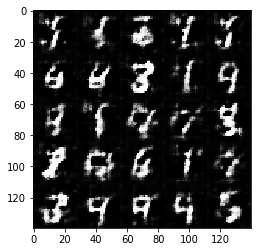

Epoch 1/2... Discriminator Loss: 0.8984... Generator Loss: 1.9524
Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 1.2259
Epoch 1/2... Discriminator Loss: 0.5749... Generator Loss: 2.2524
Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 0.9639
Epoch 1/2... Discriminator Loss: 0.6863... Generator Loss: 1.8732
Epoch 1/2... Discriminator Loss: 0.7181... Generator Loss: 1.6556
Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 1.9061
Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 1.7205
Epoch 1/2... Discriminator Loss: 0.8524... Generator Loss: 1.1812
Epoch 1/2... Discriminator Loss: 0.7019... Generator Loss: 1.8561


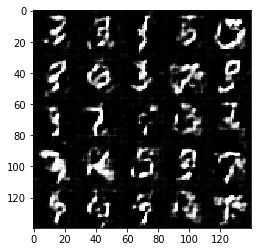

Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 1.4913
Epoch 1/2... Discriminator Loss: 0.6191... Generator Loss: 1.8250
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 2.1992
Epoch 1/2... Discriminator Loss: 0.6833... Generator Loss: 1.8314
Epoch 1/2... Discriminator Loss: 0.7348... Generator Loss: 2.1995
Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 1.5353
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.1258
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.1992
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.3493


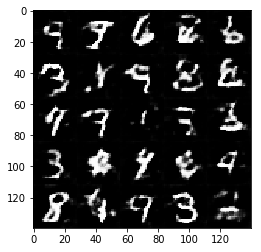

Epoch 1/2... Discriminator Loss: 0.7099... Generator Loss: 1.6676
Epoch 1/2... Discriminator Loss: 0.7701... Generator Loss: 2.9314
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 2.4145
Epoch 1/2... Discriminator Loss: 0.6310... Generator Loss: 1.9231
Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 1.1243
Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 1.2534
Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 1.8378
Epoch 1/2... Discriminator Loss: 0.6418... Generator Loss: 2.4318
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 2.8539
Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 1.2298


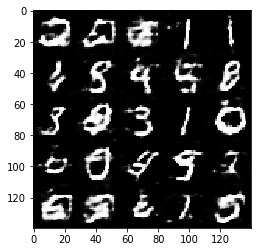

Epoch 1/2... Discriminator Loss: 0.6728... Generator Loss: 1.7461
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 1.3917
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 1.9878
Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 2.0217
Epoch 1/2... Discriminator Loss: 0.7727... Generator Loss: 2.0756
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 0.6770... Generator Loss: 1.5857
Epoch 1/2... Discriminator Loss: 1.5422... Generator Loss: 0.5040
Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 1.4578


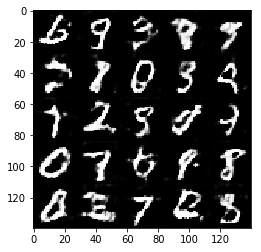

Epoch 1/2... Discriminator Loss: 0.9268... Generator Loss: 1.1521
Epoch 1/2... Discriminator Loss: 0.8533... Generator Loss: 1.1549
Epoch 1/2... Discriminator Loss: 0.8738... Generator Loss: 1.1184
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.6695
Epoch 1/2... Discriminator Loss: 0.8182... Generator Loss: 1.2873
Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.9906
Epoch 1/2... Discriminator Loss: 2.6828... Generator Loss: 0.1780
Epoch 1/2... Discriminator Loss: 0.7981... Generator Loss: 1.1972
Epoch 1/2... Discriminator Loss: 0.8021... Generator Loss: 1.6014
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 0.8353


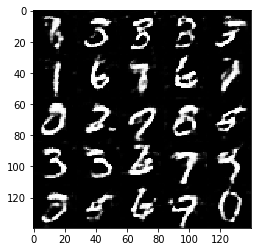

Epoch 1/2... Discriminator Loss: 0.6308... Generator Loss: 1.6420
Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 1.3147
Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 1.1357
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.2301
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 0.8251
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 1.2557
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 0.9473
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 1.4977
Epoch 2/2... Discriminator Loss: 0.6613... Generator Loss: 2.5597


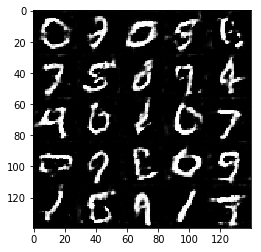

Epoch 2/2... Discriminator Loss: 0.7366... Generator Loss: 1.3178
Epoch 2/2... Discriminator Loss: 0.6710... Generator Loss: 1.7527
Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 0.5514
Epoch 2/2... Discriminator Loss: 1.1219... Generator Loss: 0.7243
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 0.5444
Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 1.1502
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 1.7530
Epoch 2/2... Discriminator Loss: 0.8190... Generator Loss: 2.8024
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 1.2464... Generator Loss: 0.5936


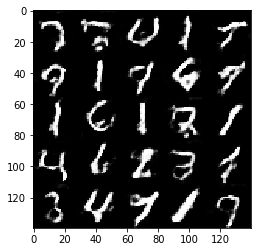

Epoch 2/2... Discriminator Loss: 0.7613... Generator Loss: 1.3201
Epoch 2/2... Discriminator Loss: 0.8412... Generator Loss: 1.0784
Epoch 2/2... Discriminator Loss: 0.8428... Generator Loss: 1.8123
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.4684
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.0406
Epoch 2/2... Discriminator Loss: 0.6570... Generator Loss: 1.7220
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 0.9532
Epoch 2/2... Discriminator Loss: 0.7175... Generator Loss: 1.9924
Epoch 2/2... Discriminator Loss: 0.6767... Generator Loss: 1.5544
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.8587


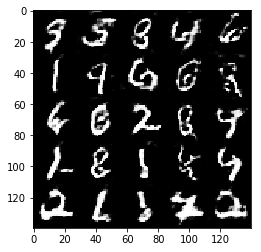

Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.5183
Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 1.7829
Epoch 2/2... Discriminator Loss: 1.1404... Generator Loss: 0.7738
Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 1.2431
Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 0.5322
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 2.2604
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.4609
Epoch 2/2... Discriminator Loss: 1.0456... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 1.1959


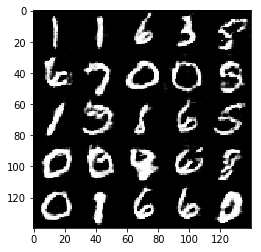

Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 1.7533
Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 1.8218
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 0.8197... Generator Loss: 1.1158
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 1.1290
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.2034
Epoch 2/2... Discriminator Loss: 0.7030... Generator Loss: 1.9437
Epoch 2/2... Discriminator Loss: 0.8461... Generator Loss: 1.0570
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 1.5119
Epoch 2/2... Discriminator Loss: 0.7909... Generator Loss: 1.1822


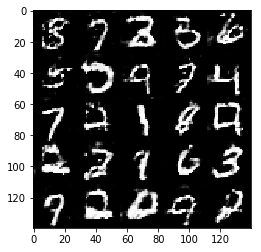

Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 0.9481
Epoch 2/2... Discriminator Loss: 1.4164... Generator Loss: 0.4552
Epoch 2/2... Discriminator Loss: 0.7292... Generator Loss: 1.3783
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 0.6049... Generator Loss: 1.5690
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 3.1754
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 1.6579
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.0523
Epoch 2/2... Discriminator Loss: 0.6208... Generator Loss: 1.7068


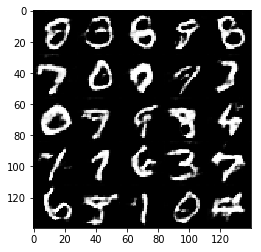

Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.5888
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.6412
Epoch 2/2... Discriminator Loss: 1.2364... Generator Loss: 0.6413
Epoch 2/2... Discriminator Loss: 1.8217... Generator Loss: 0.3542
Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 2.2100
Epoch 2/2... Discriminator Loss: 0.6487... Generator Loss: 1.9016
Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 1.7419
Epoch 2/2... Discriminator Loss: 0.7158... Generator Loss: 1.2781
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.0212


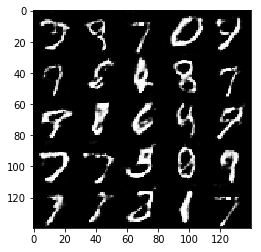

Epoch 2/2... Discriminator Loss: 0.6756... Generator Loss: 1.3889
Epoch 2/2... Discriminator Loss: 1.9361... Generator Loss: 0.3210
Epoch 2/2... Discriminator Loss: 0.6198... Generator Loss: 1.5484
Epoch 2/2... Discriminator Loss: 0.5788... Generator Loss: 1.7406
Epoch 2/2... Discriminator Loss: 0.6649... Generator Loss: 1.4523
Epoch 2/2... Discriminator Loss: 0.5230... Generator Loss: 1.8953
Epoch 2/2... Discriminator Loss: 0.7684... Generator Loss: 1.6781
Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 1.2842
Epoch 2/2... Discriminator Loss: 1.5442... Generator Loss: 0.4426
Epoch 2/2... Discriminator Loss: 0.5760... Generator Loss: 1.6766


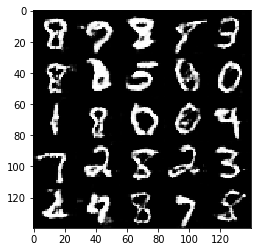

Epoch 2/2... Discriminator Loss: 0.9708... Generator Loss: 0.8679
Epoch 2/2... Discriminator Loss: 1.4904... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 0.6000... Generator Loss: 1.9371
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.6157
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.0281
Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 0.6377... Generator Loss: 1.5595
Epoch 2/2... Discriminator Loss: 0.7811... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 0.7479
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.5319


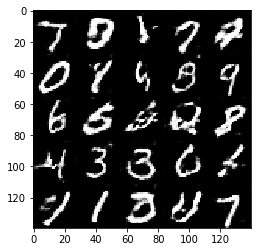

Epoch 2/2... Discriminator Loss: 0.6382... Generator Loss: 2.3009
Epoch 2/2... Discriminator Loss: 1.0852... Generator Loss: 0.7045
Epoch 2/2... Discriminator Loss: 0.8165... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 1.5364
Epoch 2/2... Discriminator Loss: 1.8075... Generator Loss: 0.4118
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.5771
Epoch 2/2... Discriminator Loss: 1.6420... Generator Loss: 0.4354


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 7.2037... Generator Loss: 0.0019
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 8.8293
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 6.3258
Epoch 1/1... Discriminator Loss: 2.0222... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.6183
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 3.7128
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 3.6052
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 2.0035
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 5.4290


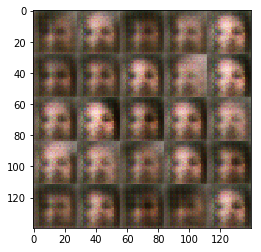

Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 6.7582
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 2.1853
Epoch 1/1... Discriminator Loss: 2.6229... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.5259
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.6487
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 2.0150
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.5231


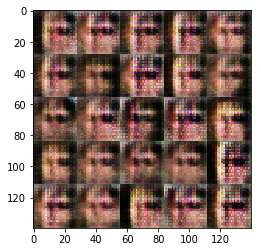

Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.7935
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 2.4448
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 2.3525
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 2.4519
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 1.7246
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.9221


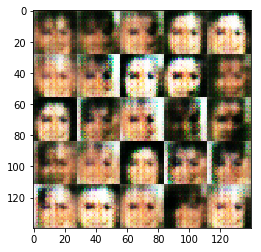

Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 2.4373
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.6345
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 3.3109
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 1.4672
Epoch 1/1... Discriminator Loss: 1.8069... Generator Loss: 0.3569
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 2.1774
Epoch 1/1... Discriminator Loss: 0.6330... Generator Loss: 1.7189


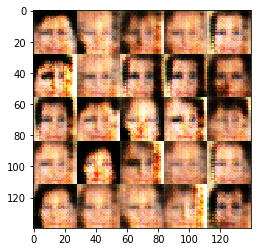

Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 2.2593
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 2.5421
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 2.2884
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 1.7783
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.5055
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 2.0810


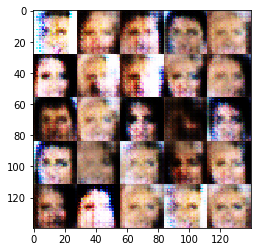

Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 3.6604
Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 2.2909
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 1.9084
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.3763
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 3.3825
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 2.5885
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.1895
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5955


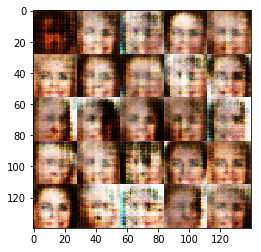

Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 4.4506
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 2.2991
Epoch 1/1... Discriminator Loss: 1.8452... Generator Loss: 0.3142
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 1.6896
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 2.0885
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.8513
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 2.3649
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.5272


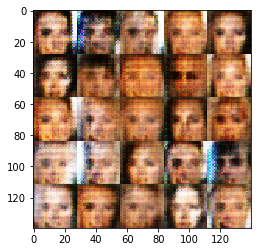

Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 5.2321
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 2.7506
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 2.2873
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 3.4786
Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 2.2485
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 1.9510
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.1346


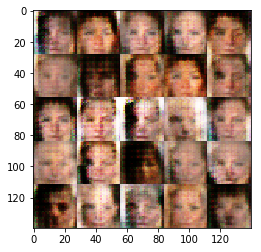

Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 2.4219
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 2.7871
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 2.4704
Epoch 1/1... Discriminator Loss: 1.6868... Generator Loss: 4.8427
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.7891
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 1.7098


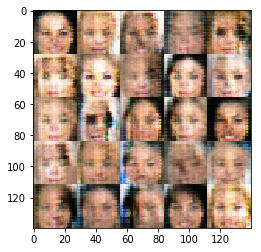

Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 2.3726
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 2.4123
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.8581
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 2.9959
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 2.6796
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 2.8652
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.5599
Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 2.1367


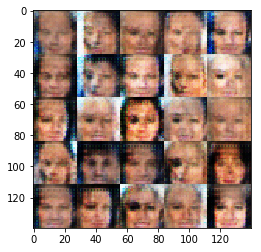

Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 0.7132... Generator Loss: 1.8362
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 2.4210
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.3270
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.1647
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 2.1412
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.7536


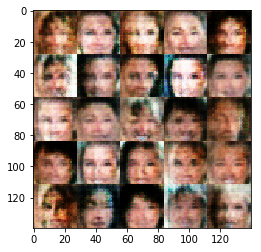

Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 3.9872
Epoch 1/1... Discriminator Loss: 3.1076... Generator Loss: 7.8035
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.7801
Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 1.7719
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.7505
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 4.0726
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.5313
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 2.4358
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.4395


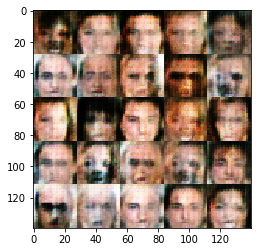

Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 3.5540
Epoch 1/1... Discriminator Loss: 1.7936... Generator Loss: 4.9323
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.6146
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 3.4240
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 3.8551
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 3.3072
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 3.7038
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.1990


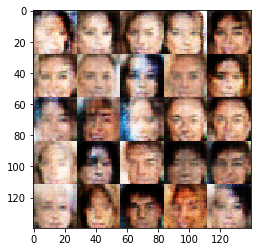

Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 2.9874
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 2.3321
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.6965... Generator Loss: 0.3757
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.1963
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 1.4049
Epoch 1/1... Discriminator Loss: 1.6966... Generator Loss: 5.0139
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.4619


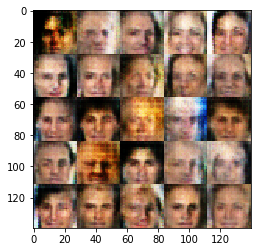

Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 2.3926
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 2.2663
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.6555
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.7338
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.3363
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 2.3218
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 2.0893


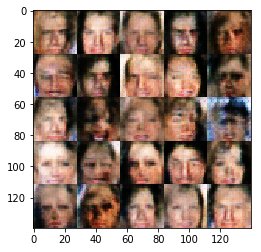

Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.6756
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 1.6850
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 4.9218
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 3.0773
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 4.0896
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 2.3846


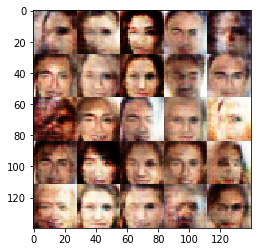

Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 2.6186
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.4983
Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 2.5362
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 1.5931
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.4166
Epoch 1/1... Discriminator Loss: 0.7278... Generator Loss: 2.4252
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 3.3244
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.6277
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 4.1498


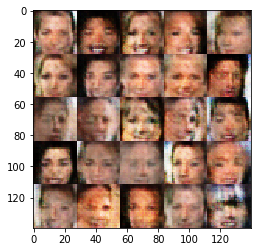

Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 1.3548
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.4575
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.6278
Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 3.0052
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 2.6214
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 2.7497


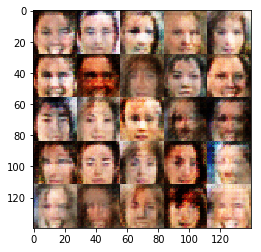

Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.9961
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 1.7147
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 3.6141
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 2.4566
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 4.6565
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 2.0616
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 2.9336
Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 3.2522


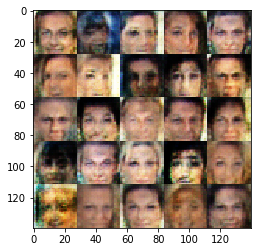

Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 1.7929... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 2.6071
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 1.4724
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.5556
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 2.8262
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.7608


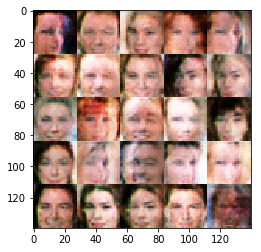

Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 2.9825
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 0.5925... Generator Loss: 2.1181
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 2.2412
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 1.8187
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.3554
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 1.9296
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.4607


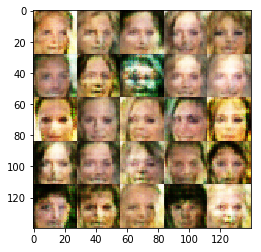

Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 2.0554
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 1.3546
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 2.4699
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 4.1586
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 2.8141
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 0.7370... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 1.7687
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.7607


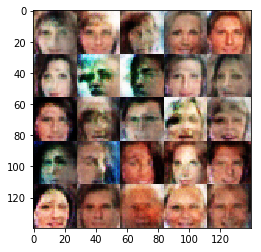

Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 2.2606
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 3.8830
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 2.5627
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 2.0593
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 2.0786
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.0493


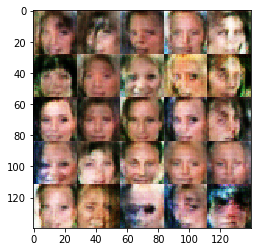

Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 1.4841
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.8721
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 3.6479
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 1.6872
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.3624
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 2.1625
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 1.4198
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.6147


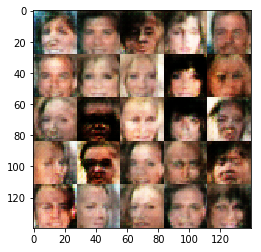

Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 2.2806
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.7713
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.8979
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 2.2234... Generator Loss: 4.9398
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.6478
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 1.3595


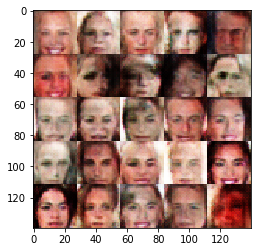

Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 1.7880
Epoch 1/1... Discriminator Loss: 1.6168... Generator Loss: 0.3775
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 2.1006
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 2.0021
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 3.5642
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 2.1550
Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 1.8959
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 2.2674


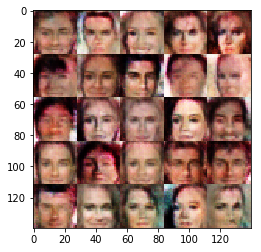

Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.3383
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 2.4561
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 1.3814
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.8793
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 3.0923
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 1.2386
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 2.7780


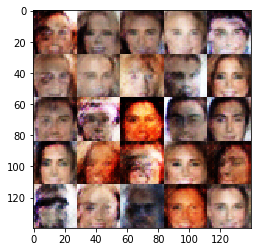

Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 1.9335
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 2.3422
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.3679
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 1.8185
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 2.4255


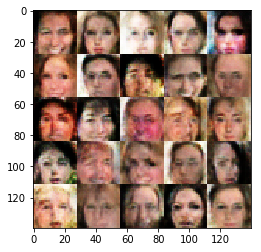

Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.5513
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 2.7240
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 2.3578
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 0.7348... Generator Loss: 1.4133
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 2.8459
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 3.1131


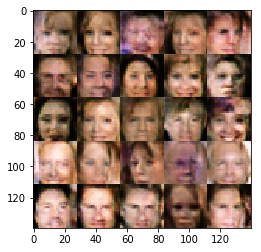

Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 1.5937
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 1.3866
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 2.6260
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.3618
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 4.6123
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.3513
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.3277


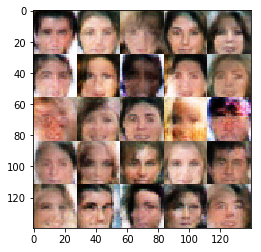

Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 2.9282
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.3317
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 3.4532
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 1.5227
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 1.6711
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.7257


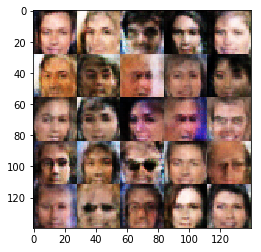

Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 2.1256
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 3.1326
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.4249


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.